In [53]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 모델 훈련

## 선형 회귀

<img src="https://t1.daumcdn.net/cfile/tistory/997296395B87835912?download" width="300px"/><br>
선형 회귀 모델은 다음과 같은 식을 따른다 (이 때, 0번째 세타는 편향(bias)이다)  
파라미터들을 훈련 세트에 잘 맞게 설정해야 하는데 이 과정을 훈련과정이라 부른다<br><br>
<img src="https://yganalyst.github.io/assets/images/ML/chap3/mse_func.png" width="300px"/>  
MSE식은 다음과 같고 입력값과 파라미터의 전치 행렬을 곱한값과 정답의 제곱 평균 오차를 구한다.  
<img src="https://yganalyst.github.io/assets/images/ML/chap3/normal_equation.jpg" width="300px"/>  
비용 함수를 최소화하는 파라미터값을 찾기 위한 해석적인 방법으로 정규방정식(normal equation)이 있다.

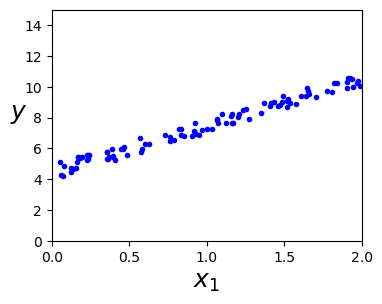

In [1]:
import numpy as np
import matplotlib.pyplot as plt

X = 2*np.random.rand(100,1)
y = 4 + 3*X + np.random.rand(100,1)

plt.style.use('default')
plt.figure(figsize=(4,3))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show() # 무작위로 생성한 선형 데이터셋

정규 방정식을 이용하여 파라미터를 계산해보자  
np.linalg.inv()를 이용하면 역행렬을 계산할 수 있다.

In [2]:
#편향 (X0)값도 구해야 하므로 모든 샘플에 X0 = 1을 더해준다

X_b = np.c_[np.ones((100,1)),X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[4.49745992],
       [2.98939265]])

In [3]:
# 각각 x가 0,2일 때 결과를 저장한다. (그래야 선을 그리지)
# np.ones((2,1))을 통해 편향값이 더해지도록 한다

X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 4.49745992],
       [10.47624522]])

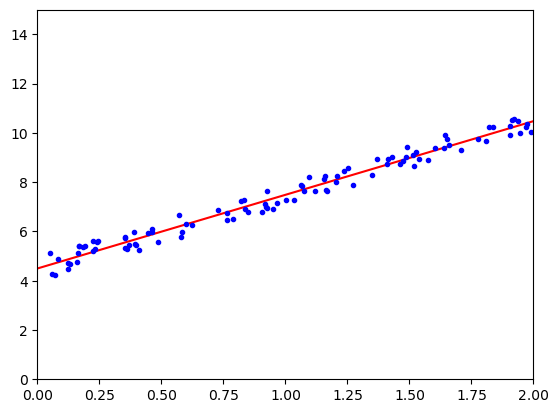

In [4]:
plt.plot(X_new,y_predict,"r-")
plt.plot(X,y,"b.")
plt.axis([0,2,0,15])
plt.show()

In [5]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)
# 여기서 intercept는 bias를 제외한 모델 파라미터, coef는 bias값이다
print(lin_reg.intercept_, lin_reg.coef_)
print(lin_reg.predict(X_new))

[4.49745992] [[2.98939265]]
[[ 4.49745992]
 [10.47624522]]


LinearRegression 클래스는 scipy.linalg.lstsp()함수를 기반으로 하므로 이를 직접 호출가능

In [6]:
theta_best_svd, residuals,rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.49745992],
       [2.98939265]])

X의 유사역행렬(preudoinverse, 정확히는 Moore-Penrose 역행렬)을 구해주는 pinv()함수  
만약 m<n 이거나 어떤 특성이 중복되어 X와 X의 전치행렬간의 곱의 역행렬이 없다면(특이 행렬이라면)  
정규방정식이 작동하지 않지만, 유사역행렬은 언제나 작동한다.<br><br>

3\*3 기준으로 역행렬 구하는 방법<br>
https://ko.wikihow.com/3x3-%EC%97%AD%ED%96%89%EB%A0%AC-%EA%B5%AC%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95<br>
3\*3 기준으로 행렬식 구하는 방법<br>
https://ko.wikihow.com/3x3-%ED%96%89%EB%A0%AC%EC%9D%98-%ED%96%89%EB%A0%AC%EC%8B%9D-%EA%B5%AC%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95


In [7]:
np.linalg.pinv(X_b).dot(y)

array([[4.49745992],
       [2.98939265]])

## 경사 하강법 (GD)

선형 회귀에서 특성이 많아지고 샘플도 많아지면 n^2에 돌아가는 LinearRegression으론 버겁다.  
이럴 때는 GD를 돌리는게 도움이 된다.  
물론 GD가 전역 최솟값을 못찾을 수 있지만 선형함수의 MSE는 볼록함수임이 보장되기에 상관없다.  
다만 GD를 돌리기전에 특성끼리의 크기는 맞춰줘야 시간이 적게 걸린다.

In [8]:
eta = 0.1
n_iter = 1000
m = 100

theta = np.random.randn(2,1)

for it in range(n_iter):
    gradients = 2/m*X_b.T.dot(X_b.dot(theta)-y)
    theta = theta-eta*gradients
theta

array([[4.49745992],
       [2.98939265]])

### 확률적 경사 하강법 (SGD)

모든 훈련 세트를 쓰는 GD와 달리 매 스텝마다 한 개의 샘플을 무작위로 선택해서 계산하는 SGD는 빠르긴하다.  
GD와 달리 지역 최솟값보다는 전역 최솟값을 찾을 확률이 높지만 불안정하다.  
무작위성이 지역 최솟값에서 벗어나게 해주지만 그와 동시에 전역 최솟값을 못찾게 하는 원인이 된다.  
이를 해소하기 위해 학습률을 점차 감소 시키는 방법이 있고 이를 실행하는 함수를 학습(률) 스케줄이라고 부른다.  
너무 빨리 줄어들면 지역 최솟값에 갇히거나 멈출 수 있고  
너무 천천히 줄어들면 최솟값 주변을 맴돌게 되거나 일찍 훈련이 종료된다.

In [9]:
n_epochs = 50  # 전체 데이터를 50번 본다
t0, t1 = 5, 50

def learning_schedule(t):
    return t0 / (t + t1)


theta = np.random.randn(2, 1)

for epochs in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index + 1]
        yi = y[random_index:random_index + 1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epochs * m + i) # 현재 학습 회수에 대하여 큰 가중치를 부여
        theta = theta - eta * gradients
theta

array([[4.47861057],
       [2.97294916]])

In [10]:
from sklearn.linear_model import SGDRegressor

# tol은 손실함수가 tol값보다 작아지면 반복을 멈추게 해준다.
sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3,penalty=None,eta0=0.1)
sgd_reg.fit(X,y.ravel())
sgd_reg.intercept_,sgd_reg.coef_

(array([4.50039516]), array([3.02260131]))

### 미니 배치 경사 하강법

당연하게도 I/O 속도가 워낙 느리기에 모든 데이터를 하나씩 보내는 것보다 좀 뭉쳐서 보내는 것이 빠르다.  
특히 행렬 연산에 최적화된 GPU에서 더 유리한 측면이 있다.  
게다가 미니배치가 클수록 SGD를 이용할 때 더 불규칙하게 움직이는 측면이 있다.

## 다항 회귀

가지고 있는 데이터의 형태가 직선이 아닌 비선형 형태여도 선형 모델을 이용할 수 있다.  
각 특성의 거듭제곱을 새로운 특성으로 추가하고 이 확장된 특성을 포함한 데이터셋에 선형 모델을 학습하면 된다.

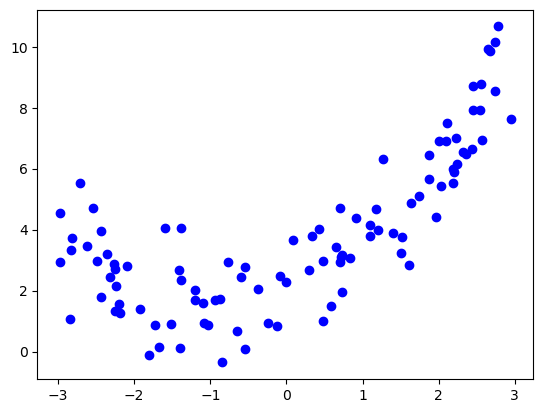

In [11]:
m = 100
X = 6* np.random.rand(m,1)-3
y = 0.5*X**2 + X+2+np.random.randn(m,1)
plt.plot(X,y,"bo")

In [12]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
print(X.shape, X_poly.shape)  # X의 모든 특성에 제곱을 해서 추가시켜준다.

(100, 1) (100, 2)


In [13]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([2.01332093]), array([[0.99437005, 0.52815282]]))

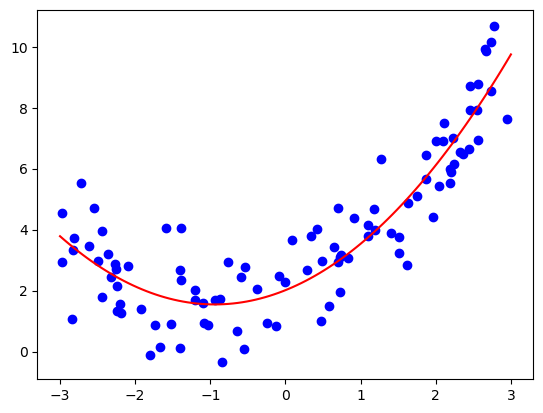

In [14]:
X_new=np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X,y,"bo")
plt.plot(X_new,y_new,"r-")

## 학습 곡선

방금 데이터에 대해서 고차 다항 회귀를 적용하면 확실히 훈련 데이터를 잘 학습하긴한다.  
하지만 새로운 데이터에 대해서는 취약해진다 (과대적합)  
그 반대로 선형 회귀는 과소적합이 일어나는데 이 처럼 과대,과소적합을 알아내기 위해 학습 곡선을 그리면 된다.

In [15]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X,
                                                      y,
                                                      test_size=0.2,
                                                      random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train) + 1):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)  # 책에는 없음
    plt.xlabel("Training set size", fontsize=14)  # 책에는 없음
    plt.ylabel("RMSE", fontsize=14)  # 책에는 없음

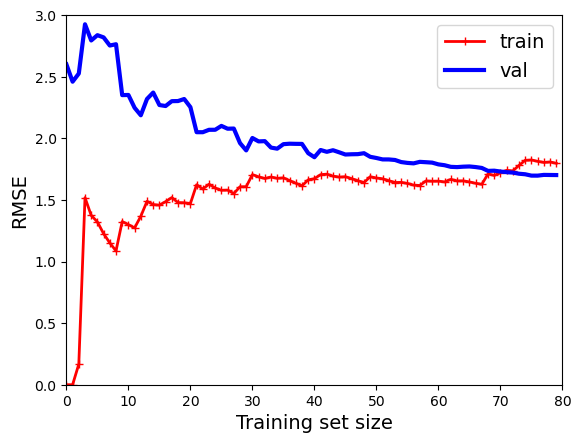

In [16]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 3])                         # 책에는 없음
plt.show()            

전형적인 과소적합의 사례인데 하나의 데이터에서는 잘 작동하지만 샘플이 늘어날수록 완전히 따라가는 것이 불가능하다.<br>따라서 점점 오차율이 늘어나는 것을 볼 수 있다.<br>
반면 검증 데이터의 오차율을 샘플이 추가될 수록 일반화가 되어 줄어들 수 있지만 완전히 일반화하는 것이 <br>불가능하기때문에 점점 오차율 감소폭이 완만해지다가 가까워지고 끝나게된다.

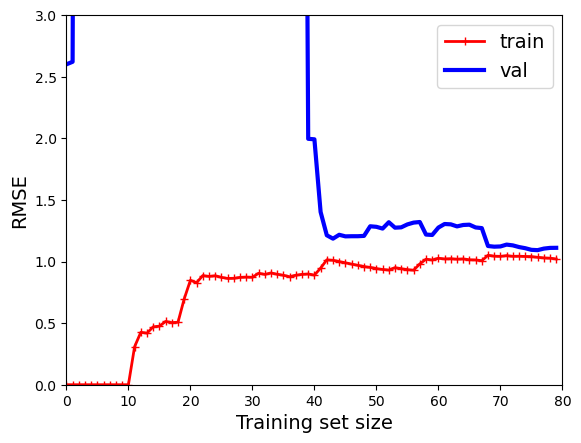

In [17]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

과소적합과 비슷해보이지만 과대적합 그래프이다.  
확실히 훈련 데이터상에서 에러율이 낮지만 검증 데이터와의 간격이 크다.(훈련 데이터에 편향됬기 때문)  
다만 훈련 데이터가 커진다면 그 차이가 줄어든다.

## 규제가 있는 선형 모델

### 릿지 회귀
모델의 가중치가 커질수록 과대적합되기가 쉽다.  
이를 막기 위하여 특성의 L2 노름의 0.5를 곱한 값을 손실함수에 더해준다.  
규제의 정도를 나타내기 위하여 $\alpha$ 를 곱해준다.  
릿지 회귀의 비용 함수는 다음과 같다.  
J($\theta$) = MSE($\theta$) + $\alpha$$\frac{1}{2}$$\sum_{i=1}^{n}\theta^{2}$ (단, 편향 $\theta_{0}$는 제외)

In [18]:
from sklearn.linear_model import Ridge

np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

# 숄레스키가 발견한 행렬 분해를 이용한 정규방정식 활용한 회귀
ridge_reg = Ridge(alpha=1, solver="cholesky")
ridge_reg.fit(X,y)
ridge_reg.predict([[1.5]])

array([[1.55071465]])

In [19]:
from sklearn.linear_model import SGDRegressor

# L2규제가 릿지 회귀와 같기 때문에 이용
sgd_reg = SGDRegressor(penalty="l2")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([1.46543286])

### 라쏘 회귀
릿지 회귀와 달리 L1노름을 이용하는 라쏘 회귀도 있다.  
J($\theta$) = MSE($\theta$) + $\alpha$$\sum_{i=1}^{n}|\theta_{i}|$ (단, 편향 $\theta_{0}$는 제외)  
라쏘 회귀는 덜 중요한 특성의 가중치를 제거하려는 특성이 있다. (즉, 자동으로 특성을 선택하고 희소 모델을 만든다)   
다만 $\theta_{i}$ (i=1,2,...,n) = 0 일 때, 미분불가능하지만 subgradient vector, g 를 이용하면 GD를 사용할 때 문제가 없다.  
<img src="https://media.vlpt.us/images/kangtae/post/eea9042a-d1d5-43b0-a045-a2c440ccb5d8/lasso%20subgradient%20vector.png" width="500px"/>

In [20]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X,y)
lasso_reg.predict([[1.5]])

array([1.53788174])

In [21]:
# 당연하게도 L1규제와 lasso회귀는 동일하다

sgd_reg = SGDRegressor(penalty="l1")
sgd_reg.fit(X,y.ravel())
sgd_reg.predict([[1.5]])

array([1.46938541])

### 엘라스틱넷
릿지와 라쏘를 섞은 모델이다. 혼합 비율 파라미터인 r로 조절 가능.  
만약 많은 특성들 중, 일부만 쓴다고 판단되면 라쏘를, 아니라면 릿지를 쓰자  
그런데 라쏘를 사용할 때 특성 수가 훈련 샘플보다 많거나 특성끼리 강하게 연관되어 있다면 엘라스틱넷을 쓰자.  
J($\theta$) = MSE($\theta$) + r$\alpha$$\sum_{i=1}^{n}|\theta_{i}|$ + $\frac{1-r}{2}$$\alpha$$\sum_{i=1}^{n}\theta_{i}^2$

In [22]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

### 조기 종료
경사 하강법과 같이 반복 학습 알고리즘을 이용하다보면 검증 에러가 시간이 지날수록 증가한다.  
이를 막기 위하여 검증 에러가 증가하기 전에 학습을 종료하면 된다.  
얼마나 간단하면 공짜 점심 없다는 경제학 용어를 뒤집는 "훌륭한 공짜 점심" 이라는 말이 붙었다. (by 제프리 힌턴)

In [23]:
from sklearn.model_selection import train_test_split

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)

X_train, X_val, y_train, y_val = train_test_split(X, y.ravel(), test_size=0.5, random_state=10)

In [24]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler

poly_scaler = Pipeline([("poly_features",
                         PolynomialFeatures(degree=90, include_bias=False)),
                        ("std_scaler", StandardScaler())])
X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.fit_transform(X_val)

sgd_reg = SGDRegressor(max_iter=1,
                       tol=-np.infty, # 조기 종료되는 조건
                       warm_start=True, # True이면 새로 훈련을 시작하지않고 이전 상황에서 이어감
                       penalty=None,
                       learning_rate="constant",
                       eta0=0.0005)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train)
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)

In [25]:
print(best_epoch,'\n',best_model,'\n',minimum_val_error)

154 
 SGDRegressor(eta0=0.0005, learning_rate='constant', max_iter=1, penalty=None,
             tol=-inf, warm_start=True) 
 1.0212282226469136


## 로지스틱 회귀
어떤 회귀 알고리즘은 분류에도 쓰인다 (vice versa)  
예를 들어 특정 데이터가 어떤 클래스에 들어갈 확률을 계산해내고 그 값이 50% 이상이면 속한다고 치는 식

### 확률 추정
선형 회귀와 마찬가지로 입력 특성의 가중치 합을 구하고, 편향을 더해준다.  
대신 선형 회귀처럼 바로 결과를 출력하지 않고 결괏값의 로지스틱$\sigma$을 출력한다.  
추정값 = $\sigma(\theta^{T}x)$  
확률의 경우 로지스틱은 0과 1사이의 값을 출력하는 sigmoid 함수가 된다. $\sigma(t) = \frac{1}{1+exp(-t)}$

### 훈련과 비용 함수

확률에 대한 비용함수는 로그 손실을 이용하여 표현할 수 있다.<br>
<br>
\begin{equation}
  c(\theta)=\begin{cases}
    -log(\hat{p}), & \text{y = 1}.\\
    -log(1-\hat{p}), & \text{y = 0}.
  \end{cases}
\end{equation}<br>
당연하게도 y가 양성인 경우 확률이 높아야 손실이 적어야 하고 음성인 경우 확률이 낮아야 손실이 낮다<br>
이를 종합해서 전체 훈련 세트에 대한 비용 함수는 모든 훈련 샘플의 비용을 평균한 값이다.<br>
<br>
\begin{equation}
 J(\theta) = -\frac{1}{m}\sum^{m}_{i=1}[y^{(i)}log(\hat{p}^{(i)})+(1-y^{(i)})log(1-\hat{p}^{(i)})]
\end{equation}<br>
그런데 이식을 계산하려면 비용이 엄청나지만 j번째 모델 파라미터에 대해 편미분을 진행하면 다음과 같다<br>
<img src="https://yganalyst.github.io/assets/images/ML/chap3/logistic6.png" width="300px"/><br>
그런데 이 식은 MSE의 편도함수와 굉장히 유사하다. (각 샘플의 예측 오차를 계산하고 j번째 특성값을 곱한 뒤 구한 평균값)<br>
이런 식으로 모든 편도함수를 포함한 기울기 벡터를 만들면 배치 경사 하강법을 사용할 수 있다.

### 결정 경계

In [26]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [34]:
print(iris.DESCR) # sepal -> 꽃받침, petal -> 꽃잎

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [39]:
X = iris["data"][:, 3:]
y = (iris["target"] == 2).astype(np.int)

C:\Users\hesh0\AppData\Local\Temp/ipykernel_3504/4102839179.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = (iris["target"] == 2).astype(np.int)


In [47]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X,y)

LogisticRegression()

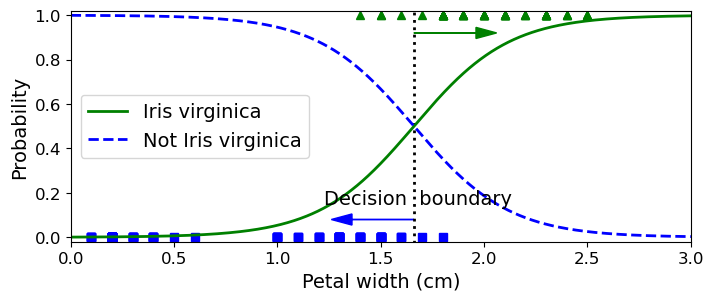

In [55]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0]

plt.figure(figsize=(8, 3))
plt.plot(X[y==0], y[y==0], "bs")
plt.plot(X[y==1], y[y==1], "g^")
plt.plot([decision_boundary, decision_boundary], [-1, 2], "k:", linewidth=2)
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica")
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2, label="Not Iris virginica")
plt.text(decision_boundary+0.02, 0.15, "Decision  boundary", fontsize=14, color="k", ha="center")
plt.arrow(decision_boundary[0], 0.08, -0.3, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(decision_boundary[0], 0.92, 0.3, 0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.xlabel("Petal width (cm)", fontsize=14)
plt.ylabel("Probability", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 3, -0.02, 1.02])
plt.show()

### 소프트맥스 회귀
여러개의 이진 분류기를 훈련시켜 연결하지 않더라도 직접 다중 클래스를 지원할 수 있다.  
이를 소프트맥스 회귀라고 부르며 ***다항 로지스틱 회귀*** 라고 부른다.  
<br>
\begin{equation}
    s_{k}(x)=(\theta^{(k)})^Tx
\end{equation}<br>
여러 클래스 k가 있을 때, 각각의 클래스 k는 자신만의 파라미터 벡터인 $\theta$를 가진다.  
(이 벡터들은 파라미터 행렬 $\Theta$에 저장되어 있다.)  
입력 값 $x$에 대한 클래스 점수가 계산되면 softmax 함수에 통과시켜서 클래스 k에 속할 확률을 구한다.<br><br>
\begin{equation}
\hat{p}_k = \sigma\left(\mathbf{s}(\mathbf{x})\right)_k = \dfrac{\exp\left(s_k(\mathbf{x})\right)}{\sum\limits_{j=1}^{K}{\exp\left(s_j(\mathbf{x})\right)}}
\end{equation}<br> 
로지스틱 회귀와 마찬가지로 소프트맥스 역시 추정 확률이 가장 높은 클래스를 선택한다.  
<br>
소프트맥스 회귀에서는 **크로스 엔트로피 (cross entropy)** 를 이용한다.  
크로스 엔트로피는 추정된 클래스의 확률이 타깃 클래스에 얼마나 잘 맞는지를 측정한다.
<br>
\begin{equation}
    J(\Theta)=-\frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}y_{k}^{(i)}log(\hat{p_{k}}^{(i)})
\end{equation}<br>
만약 i번째 샘플이 속하면 안되는 클래스에 속할 확률이 높을수록 손실함수가 증가하는 것을 볼 수 있다. (y=0 or 1)  
당연하게도 클래스 k에 대한 크로스 엔트로피의 그레디언트 벡터는 미분하면 구할 수 있다.
\begin{equation}
\nabla_{\boldsymbol{\theta}^{(k)}} \, J(\boldsymbol{\Theta}) = \dfrac{1}{m} \sum\limits_{i=1}^{m}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
\end{equation}

In [58]:
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

softmax_reg = LogisticRegression(multi_class="multinomial",
                                 solver="lbfgs",
                                 C=10,
                                 random_state=42)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial', random_state=42)

In [60]:
# 꽃잎의 길이가 5, 너비가 2인 아이리스에 대해 추정 진행
print(softmax_reg.predict([[5, 2]]))
print(softmax_reg.predict_proba([[5, 2]]))

[2]
[[6.38014896e-07 5.74929995e-02 9.42506362e-01]]


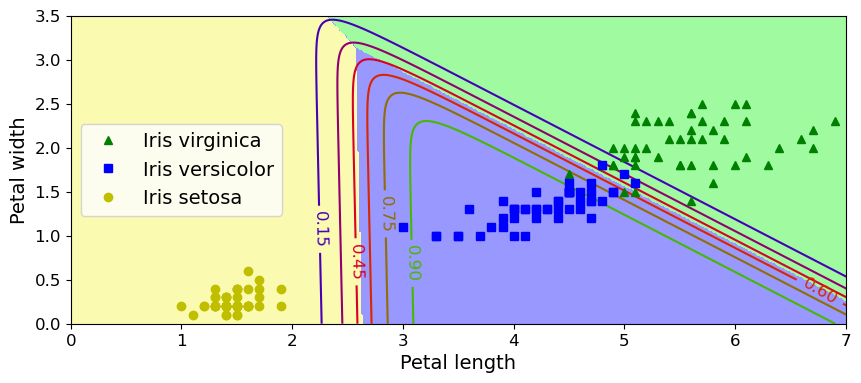

In [61]:
x0, x1 = np.meshgrid(
    np.linspace(0, 8, 500).reshape(-1, 1),
    np.linspace(0, 3.5, 200).reshape(-1, 1),
)
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()